In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datacompy
import os, sys
import numpy as np

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import stats

# modele
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# methods
from imblearn.under_sampling import ClusterCentroids, NearMiss
from scipy.optimize import differential_evolution
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from ctgan import CTGAN

### Oversampling doesn't use it several times

In [17]:
#read data
df = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\SSH.csv")
print(df.columns)
df = df.drop_duplicates()

#one hot encoding column="user"
column = ["user"]
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[column])
one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(column))
df_encoded = pd.concat([one_hot_encoded, df.drop(columns=column)], axis=1)

#standarization
scaler = StandardScaler()
binary_columns = df_encoded.columns[df_encoded.nunique() == 2]
columns_to_scale = df_encoded.columns.difference(binary_columns).difference(['target'])
df_encoded[columns_to_scale] = scaler.fit_transform(df_encoded[columns_to_scale])
df_encoded = df_encoded.drop(index=76)

#split data
y = df_encoded["target"]
X = df_encoded.drop(columns=["target"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

df_train = pd.concat([X_train, y_train], axis=1) 
df_train['source'] = 'original' 
df_train.to_csv("D:\\ml\\undersampling_data\\data\\ssh\\original_data.csv")

y_test.to_csv("D:\\ml\\undersampling_data\\data\\ssh\\Test\\y_test_ori.csv")
y_train = y_train.drop(index=282)
X_test.to_csv("D:\\ml\\undersampling_data\\data\\ssh\\Test\\X_test_ori.csv")
X_train = X_train.drop(index=282)

dell = pd.concat([X_test, y_test], axis=1)      
#dell = dell.drop(columns=["Unnamed: 0"])
df_train = pd.concat([X_train, y_train], axis=1)


Index(['user', 'is_private', 'is_failure', 'is_root', 'is_valid',
       'not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'first',
       'td', 'ts', 'target'],
      dtype='object')


dodac dane z zsumowane dla NM dokonac standaryzcji i przeprowadzic uczenie maszynowe + cross

Przed Counter({0.0: 150, 1.0: 46})
     user_Hockey  user_Justin  user_Maddock  user_Mickey  user_abc123  \
0            0.0          0.0           0.0          0.0          0.0   
1            0.0          0.0           0.0          0.0          0.0   
2            0.0          0.0           0.0          0.0          0.0   
3            0.0          0.0           0.0          0.0          0.0   
4            0.0          0.0           0.0          0.0          0.0   
..           ...          ...           ...          ...          ...   
295          0.0          0.0           0.0          0.0          0.0   
296          0.0          0.0           0.0          0.0          0.0   
297          0.0          0.0           0.0          0.0          0.0   
298          0.0          0.0           0.0          0.0          0.0   
299          0.0          0.0           0.0          0.0          0.0   

     user_admin  user_admins  user_adminx  user_andrew  user_apple  ...  \
0           0

<Axes: xlabel='target'>

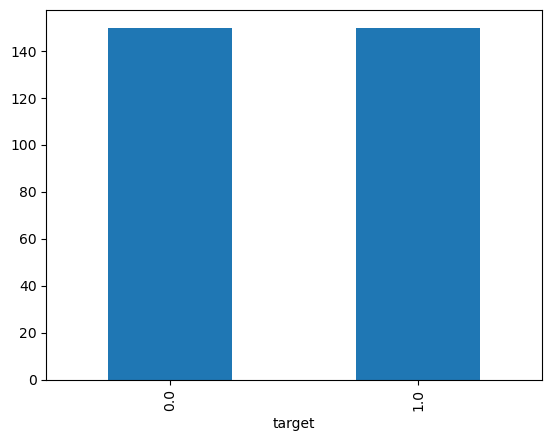

In [18]:

file_path1 = "D:\\ml\\undersampling_data\\data\\ssh\\generated\\smote_data.csv"
#zamiana jesli istnieje to wczytaj plik jesli nie to stworz
con = Counter(y_train)
print("Przed", con)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


user_columns = [col for col in X_train_sm.columns if 'user_' in col]
X_train_sm[user_columns] = X_train_sm[user_columns].round()

print(X_train_sm)

train_data_smote = pd.concat([X_train_sm, y_train_sm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_smote['generated_by_smote'] = ['original' if i < len(df_train) else 'smote' for i in range(len(train_data_smote))]
smote_data = train_data_smote[train_data_smote['generated_by_smote'] == 'smote'].drop('generated_by_smote', axis=1)
if not os.path.exists(file_path1):
    smote_data.to_csv(file_path1, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path1}')
con1 = Counter(y_train_sm)
print("Po", con1)
pd.Series(y_train_sm).value_counts().plot.bar()

Przed Counter({0.0: 150, 1.0: 46})
Po Counter({0.0: 150, 1.0: 150})
     user_Hockey  user_Justin  user_Maddock  user_Mickey  user_abc123  \
0            0.0          0.0           0.0          0.0          0.0   
1            0.0          0.0           0.0          0.0          0.0   
2            0.0          0.0           0.0          0.0          0.0   
3            0.0          0.0           0.0          0.0          0.0   
4            0.0          0.0           0.0          0.0          0.0   
..           ...          ...           ...          ...          ...   
295          1.0          0.0           0.0          0.0          0.0   
296          1.0          0.0           0.0          0.0          0.0   
297          0.0          0.0           0.0          0.0          0.0   
298          0.0          0.0           0.0          0.0          0.0   
299          0.0          0.0           0.0          0.0          0.0   

     user_admin  user_admins  user_adminx  user_andrew 

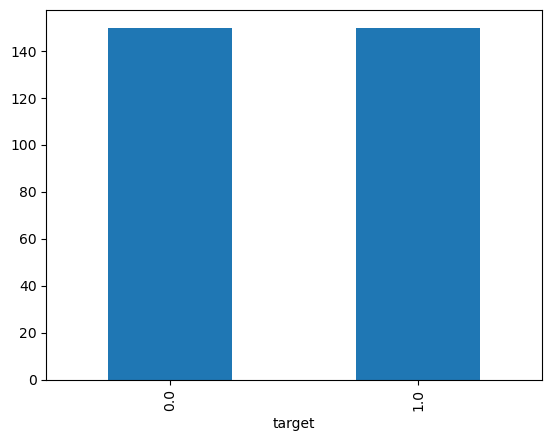

In [19]:
file_path2 = "D:\\ml\\undersampling_data\\data\\ssh\\generated\\borderline_data.csv"
#generate new data by borderLineSMOTE
con3 = Counter(y_train)
print("Przed", con3)
brdsmote = BorderlineSMOTE(random_state=42)
X_train_bsm, y_train_bsm = brdsmote.fit_resample(X_train, y_train)
con4 = Counter(y_train_bsm)
print("Po", con4)

user_columns = [col for col in X_train_bsm.columns if 'user_' in col]
X_train_bsm[user_columns] = X_train_bsm[user_columns].round()
print(X_train_bsm)
#y_train_bsm = pd.Series(y_train_bsm, name='target')

train_data_borderline_smote = pd.concat([X_train_bsm, y_train_bsm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_borderline_smote['generated_by_borderline_smote'] = ['original' if i < len(df_train) else 'brd smote' for i in range(len(train_data_borderline_smote))]
boarderline_smote_data = train_data_borderline_smote[train_data_borderline_smote['generated_by_borderline_smote'] == 'brd smote'].drop('generated_by_borderline_smote', axis=1)
#boarderline_smote_data = pd.concat([X_train_bsm, y_train_bsm], axis=1)
boarderline_smote_data["source"]="borderline smote"
boarderline_smote_data = boarderline_smote_data[boarderline_smote_data['source'] != 'original']
if not os.path.exists(file_path2):
    boarderline_smote_data.to_csv(file_path2, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path2}')
    


pd.Series(y_train_bsm).value_counts().plot.bar()
print(X_train_bsm.shape, y_train_bsm.shape)

Dane wygenerowane:  target
1    105
Name: count, dtype: int64
Before Counter({0.0: 150, 1.0: 46})
After Counter({0: 151, 1: 151})


<Axes: xlabel='target'>

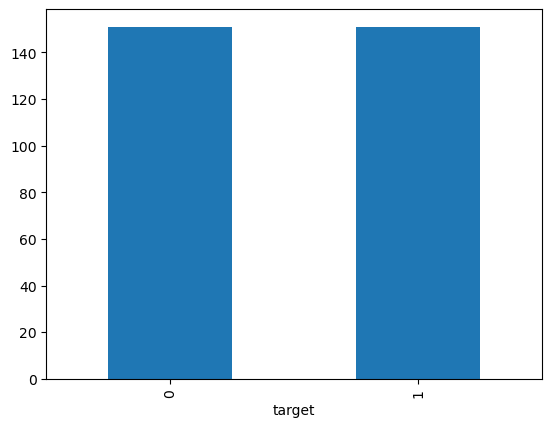

In [23]:
file_path3 = "D:\\ml\\undersampling_data\\data\\ssh\\generated\\GAN_data.csv"        #sciezka wraz z nazwa pod jaka wygenerowac plik
#generate new data by GAN

#data preparation
indexes_to_remove = y_test.index
df_gan = df.drop(index=indexes_to_remove)



columns_list = df_gan.columns
target_num = df_gan['target'].value_counts()
ctgan = CTGAN(epochs=10)        #model

if target_num[0] > target_num[1]:
    data_y1 = df_gan[df_gan['target']==1]
    ctgan.fit(data_y1, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['target'].value_counts())
    balanced_data = pd.concat([df_gan, df_GAN], ignore_index=False)
else:
    data_y0 = df_gan[df_gan['target']==0]
    ctgan.fit(data_y0, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['target'].value_counts())
    balanced_data = pd.concat([df_gan, df_GAN], ignore_index=False)



#balanced_data = balanced_data.drop(columns=["source"])  
y_train_gan = balanced_data["target"]
X_train_gan = balanced_data.drop(columns=["target"])
con5 = Counter(y_train)
print("Before", con5)
con6 = Counter(y_train_gan)
print("After", con6)
#df_GAN["source"]="gan"
gan_data = df_GAN

#one hot encoding column="user"
column = ["user"]
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded_gan = encoder.fit_transform(gan_data[column])
one_hot_encoded_gan = pd.DataFrame(one_hot_encoded_gan, columns=encoder.get_feature_names_out(column))
df_encoded = pd.concat([one_hot_encoded_gan, gan_data.drop(columns=column)], axis=1)

#standarization
scaler = StandardScaler()
binary_columns = df_encoded.columns[df_encoded.nunique() == 2]
columns_to_scale = df_encoded.columns.difference(binary_columns).difference(['target'])
df_encoded[columns_to_scale] = scaler.fit_transform(df_encoded[columns_to_scale])
gan_data = df_encoded
gan_data["source"]="gan"
if not os.path.exists(file_path3):
    gan_data.to_csv(file_path3, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path3}')

pd.Series(y_train_gan).value_counts().plot.bar()

In [ ]:
smote_data["source"] = "smote"
smote_data.to_csv("D:\\ml\\undersampling_data\\data\\ssh\\smote_data.csv", index=False)

### DATA


In [24]:
#oversampling
original_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\original_data.csv")
smote_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\smote_data.csv")
GAN_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\GAN_data.csv")
borderline_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\borderline_data.csv")

# test data
X_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\Test\\X_test_ori.csv")
y_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\Test\\y_test_ori.csv")

# reduce data
#lof_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\localoulierfactor_data.csv")
#if_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\isolationforest_data.csv")
#median_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\median_data.csv")
#cc_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\clustercentroids_data.csv")

#min_original_data = pd.read_csv("D:\\ml\\undersampling_data\\notebooks\\res.csv")

In [59]:
original_data.head()

,Unnamed: 0,user_Hockey,user_Justin,user_Maddock,user_Mickey,user_abc123,user_admin,user_admins,user_adminx,user_andrew,...,is_valid,not_valid_count,ip_failure,ip_success,no_failure,first,td,ts,target,source
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-0.439759,-0.548173,-0.116741,-0.538743,0.0,5.280450,0.532929,0.0,original
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-0.439759,-0.646608,2.339099,-0.732227,0.0,-0.118472,0.543253,0.0,original
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-0.439759,-0.548173,-0.757395,-0.538743,1.0,-0.119670,-1.944292,0.0,original
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-0.439759,-0.646608,-0.009966,-0.732227,0.0,-0.118372,0.515705,0.0,original
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-0.439759,-0.252868,1.484893,-0.055035,0.0,-0.119371,0.527594,0.0,original


In [30]:
print(GAN_data.head())
print(smote_data.head())
print(borderline_data.head())
print(original_data.head())

   user_Hockey  user_Maddock  user_Mickey  user_abc123  user_admin  \
0          0.0           0.0          0.0          0.0         1.0   
1          0.0           0.0          1.0          0.0         0.0   
2          0.0           0.0          0.0          0.0         0.0   
3          0.0           0.0          0.0          0.0         0.0   
4          0.0           0.0          0.0          0.0         1.0   

   user_adminx  user_andrew  user_apple  user_asshole  user_chris  ...  \
0          0.0          0.0         0.0           0.0         0.0  ...   
1          0.0          0.0         0.0           0.0         0.0  ...   
2          0.0          1.0         0.0           0.0         0.0  ...   
3          0.0          0.0         0.0           0.0         0.0  ...   
4          0.0          0.0         0.0           0.0         0.0  ...   

   is_valid  not_valid_count  ip_failure  ip_success  no_failure  first  \
0         1         0.642802   -1.211664   -0.578938    0.9

In [ ]:
data1 = pd.concat([GAN_data, smote_data], axis=0, ignore_index=True)
data2 = pd.concat([borderline_data, original_data], axis=0, ignore_index=True)
NM_data = pd.concat([data1, data2], axis=0, ignore_index=True)
NM_data = NM_data.reset_index(drop=True) 


y_under_NM = NM_data['target']
X_under_NM = NM_data.drop(columns=["target", "source"]) 
NM = NearMiss()
X_NM, y_NM = NM.fit_resample(X_under_NM, y_under_NM)

ValueError: Input X contains NaN.
NearMiss does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [28]:
print(NM_data.loc[314])

user_Hockey             0.0
user_Maddock            0.0
user_Mickey             0.0
user_abc123             0.0
user_admin              0.0
user_adminx             0.0
user_andrew             0.0
user_apple              0.0
user_asshole            0.0
user_chris              0.0
user_computer           0.0
user_foobar             0.0
user_fred               0.0
user_gta                0.0
user_harley             0.0
user_internet           0.0
user_jordan             0.0
user_kamran             0.0
user_money              0.0
user_mustang            0.0
user_newpass            0.0
user_notused            0.0
user_orange             0.0
user_osamac             0.0
user_passwd             0.0
user_qwerty             0.0
user_root               1.0
user_student            0.0
user_summer             0.0
user_tigger             0.0
is_private              0.0
is_failure              1.0
is_root                 1.0
is_valid                1.0
not_valid_count   -0.458837
ip_failure         0

In [29]:
nan_rows = NM_data[NM_data.isna().any(axis=1)]
print(f"Liczba wierszy z NaN: {nan_rows.shape[0]}")
print("Wiersze z NaN:")
print(nan_rows)

Liczba wierszy z NaN: 314
Wiersze z NaN:
     user_Hockey  user_Maddock  user_Mickey  user_abc123  user_admin  \
0            0.0           0.0          0.0          0.0         1.0   
1            0.0           0.0          1.0          0.0         0.0   
2            0.0           0.0          0.0          0.0         0.0   
3            0.0           0.0          0.0          0.0         0.0   
4            0.0           0.0          0.0          0.0         1.0   
..           ...           ...          ...          ...         ...   
309          1.0           0.0          0.0          0.0         0.0   
310          0.0           0.0          0.0          0.0         0.0   
311          0.0           0.0          0.0          0.0         0.0   
312          0.0           0.0          0.0          0.0         0.0   
397          NaN           NaN          NaN          NaN         NaN   

     user_adminx  user_andrew  user_apple  user_asshole  user_chris  ...  \
0            0.0  

In [3]:
# sum synthetic data
sum_syn_data = pd.concat([smote_data, borderline_data], axis=0)
sum_syn_data = pd.concat([sum_syn_data, GAN_data], axis=0)
sum_syn_data = sum_syn_data.reset_index(drop=True)

X_train_syn = sum_syn_data.drop(columns=["target", "source"])
y_train_syn = sum_syn_data["target"]

# sum all data
sum_data = pd.concat([original_data, sum_syn_data], axis=0)
sum_data = sum_data.reset_index(drop=True)
sum_data = sum_data.drop(columns=["Unnamed: 0"])

# X and y
X_train_sum = sum_data.drop(columns=["target", "source"])
y_train_sum = sum_data["target"]

# X an y drop Unnamed: 0
X_test = X_test.drop(columns=["Unnamed: 0"])
y_test = y_test.drop(columns=["Unnamed: 0"])




In [4]:
# count sum up synthetic data
syn_data = sum_syn_data.drop(columns=["source"])
num_syn = syn_data["target"].value_counts()
num_syn = int(num_syn[1])
print(f"Sum up synthetic data: {num_syn}")

# count sum up all data
num_sum = sum_data["target"].value_counts()

#calculate samples to eliminate
if num_sum[1] > 0:
    over_samples = abs(num_sum[0] - num_sum[1])
target = num_syn - over_samples
target = int(target)
print(f"Data after elimination outliers: {target}")

Sum up synthetic data: 330
Data after elimination outliers: 110


#### Standarization

In [5]:
df_unstan = sum_syn_data.drop(columns=["source"])
df_unstan = np.array(df_unstan)
np.mean(df_unstan, axis=0)
np.std(df_unstan, axis=0)
scalar = StandardScaler()
scaled_data = scalar.fit_transform(df_unstan)
df_stan = scalar.transform(df_unstan)
np.mean(df_stan, axis=0)

array([-8.61263922e-17,  0.00000000e+00,  0.00000000e+00, -1.29189588e-16,
        2.15315981e-17, -4.30631961e-17,  0.00000000e+00,  1.29189588e-16,
        0.00000000e+00, -8.07434927e-18,  0.00000000e+00])

### ClusterCentroids - Undersampling Method

In [30]:
file_path2 = "D:\\ml\\undersampling_data\\data\\ssh\\CC_data.csv"
file_path1 = "D:\\ml\\undersampling_data\\data\\ssh\\clustercentroids_data.csv"

cluscentr = ClusterCentroids(
    voting="auto", sampling_strategy="majority", random_state=42
)

X_res_CC, y_res_CC = cluscentr.fit_resample(X_train_sum, y_train_sum)
print(y_res_CC.value_counts())

reduced_cc = pd.concat([X_res_CC, y_res_CC], axis=1)
if not os.path.exists(file_path2):
    reduced_cc.to_csv(file_path2, index=False)
else:
    print(f"Plik istnieje pod ścieżką: {file_path2}")

cc_data = pd.concat([original_data, reduced_cc], axis=0)
cc_data = cc_data.drop(columns=["Unnamed: 0"])
if not os.path.exists(file_path1):
    cc_data.to_csv(file_path1, index=False)
else:
    print(f"Plik istnieje pod ścieżką: {file_path1}")

target
0    163
1    163
Name: count, dtype: int64


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


### Differential_evolution => Himmelblau fun - Evolution Algotithm

is_private


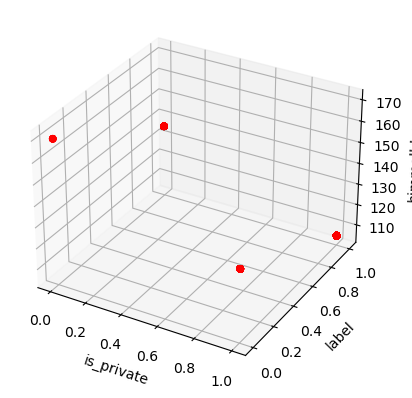

RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [ ]:
def himmelblau(x, y):
    return (x**2 + y - 11) ** 2 + (x + y**2 - 7) ** 2


features_list = X_train.columns.to_list()

for column in features_list:
    print(column)
    out_himmelblau = himmelblau(X_train[column], y_train)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X_train[column], y_train, out_himmelblau, c="r", marker="o")
    ax.set_xlabel(column)
    ax.set_ylabel("label")
    ax.set_zlabel("himmelblau")
    plt.show()

    bounds_cal = [(X_train[column].min(), X_train[column].max())]

    result = differential_evolution(func=himmelblau, bounds=bounds_cal, args=(y_train))

    print("Optymalne wartości zmiennych:", result.x)
    print("Minimalna wartość funkcji:", result.fun)


### KMeans - Clustering Algorithm

In [ ]:
kmeans = KMeans(n_clusters=4, n_init="auto", init="k-means++", random_state=0)

df = pd.DataFrame(X_train_syn)
kmeans.fit(df)
print(f"Kmeans labels: {kmeans.labels_}")
#df = pd.DataFrame(sum_data)

y_kmeans = kmeans.predict(df)

plt.scatter(df[:, 0], df[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], centers[:, 2], centers[:, 3], c='red', s=200, alpha=0.75, marker='X')
plt.title("Wyniki klasteryzacji k-średnich")
plt.xlabel("Cecha 1")
plt.ylabel("Cecha 2")
plt.show()

Kmeans labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [ ]:
df["cluster"] = Kmeans.predict(X_train)
print(df.head())

print(df["cluster"].value_counts())
# df.groupby("target", "cluster").agg({"target": "count"})

centroids = Kmeans.cluster_centers_

print("Centroidy klastrów:")
for i, centroid in enumerate(centroids):
    print(f"Klaster {i}: {centroid}")

   is_private  is_failure  is_root  is_valid  not_valid_count  ip_failure  \
0           1           1        0         1                0           4   
1           1           0        0         1                0           0   
2           1           1        1         1                0           4   
3           1           1        0         1                0           3   
4           1           1        0         1                0           1   

   ip_success  no_failure  first   td  target    source  cluster  
0          14           6      0    4       0  original        0  
1           1           0      0   23       0  original        0  
2           2           6      0  623       0  original        0  
3           0           2      0    7       0  original        0  
4           1           2      0   58       0  original        0  
cluster
0    545
1      1
Name: count, dtype: int64
Centroidy klastrów:
Klaster 0: [7.94495413e-01 8.97247706e-01 1.59633028e-01 4.8623

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to ha

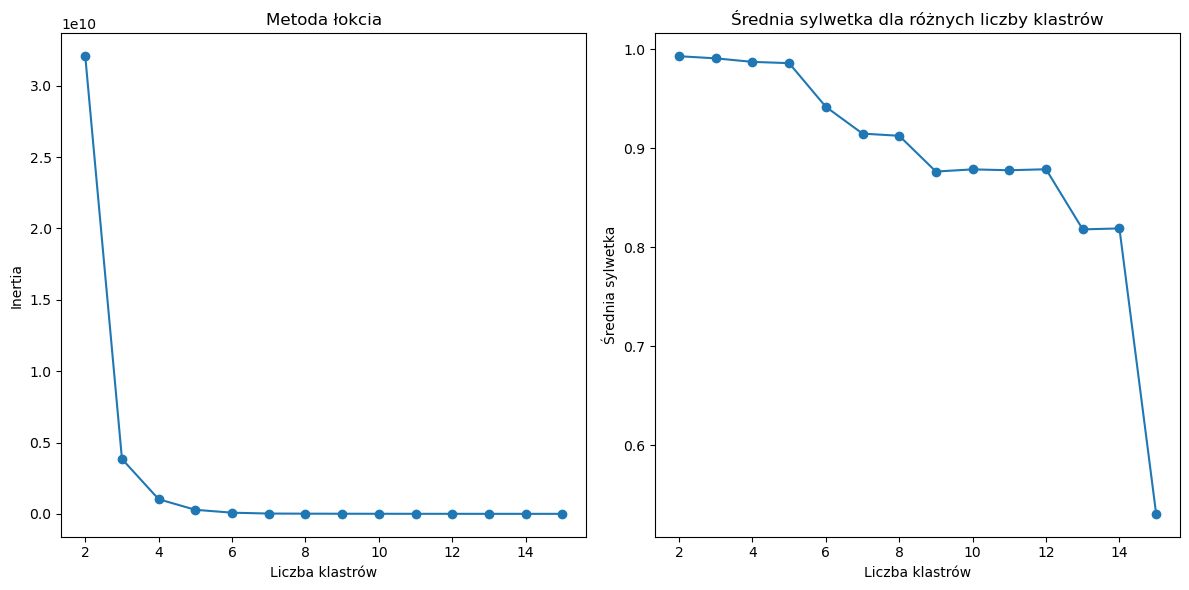

In [ ]:
# Metoda łokcia
inertia = []
silhouette_scores = []
range_n_clusters = range(2, 16)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))

# Wykres metody łokcia
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker="o")
plt.xlabel("Liczba klastrów")
plt.ylabel("Inertia")
plt.title("Metoda łokcia")

# Wykres średniej sylwetki
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker="o")
plt.xlabel("Liczba klastrów")
plt.ylabel("Średnia sylwetka")
plt.title("Średnia sylwetka dla różnych liczby klastrów")

plt.tight_layout()
plt.show()

### IsolationForest

In [31]:
syn_data = sum_syn_data.drop(columns=["source"])
num_syn = syn_data["target"].value_counts()
num_syn = int(num_syn[1])
print(f"Sum up synthetic data: {num_syn}")

num_sum = sum_data["target"].value_counts()

if num_sum[1] > 0:
    over_samples = abs(num_sum[0] - num_sum[1])
target = num_syn - over_samples
target = int(target)
print(f"Data after elimination outliers: {target}")


df = syn_data.copy()
df = df.drop(columns=["target"])


def iso_forest(df, perc):
    iso_forest = IsolationForest(n_estimators=200, contamination=perc, random_state=0, n_jobs=1)
    iso_forest.fit(df)
    df["anomaly"] = iso_forest.predict(df)
    df = df[df["anomaly"] == 1].copy()
    return df


def reduce_data_if(df, target):
    current = num_syn
    while current > target:
        if (target * 2) <= current:
            perc = 0.5
            df = iso_forest(df, perc)
            current = current / 2
            print(f"Current num of samples: {current}")

        else:
            temp = current - target
            perc = 1 - (target / current)
            df = iso_forest(df, perc)
            current = current - temp
            print(f"Current num of samples: {current}")

    return df


reduced_df = reduce_data_if(df, target)
print(f"Shape after data reduced: {reduced_df.shape}")

indexes = reduced_df.index.intersection(sum_syn_data.index)
reduced_IF = sum_syn_data.loc[indexes]

file_path = "D:\\ml\\undersampling_data\\data\\ssh\\reduced_IF.csv"
file_path1 = "D:\\ml\\undersampling_data\\data\\ssh\\isolationforest_data.csv"
if not os.path.exists(file_path):
    reduced_IF.to_csv(file_path, index=False)

if_data = pd.concat([original_data, reduced_IF], axis=0)
if_data = if_data.drop(columns=["Unnamed: 0"])
if not os.path.exists(file_path1):
    if_data.to_csv(file_path1, index=False)

Sum up synthetic data: 330
Data after elimination outliers: 110
Current num of samples: 165.0
Current num of samples: 110.0
Shape after data reduced: (110, 11)


### Median/Dev Algorithm

In [ ]:
#learn model on sum data to get important features
model = XGBClassifier(subsample=0.5, max_depth=8, n_jobs=1)
model.fit(X_train_sum, y_train_sum)

median_before = np.median(X_train_syn, axis=0)
std_before = np.std(X_train_syn, axis=0)
print(f"Median before:\n{median_before}")
print(f"Standard deviation before:\n{std_before}")

#visualize median and std
""" plt.figure(figsize=(8, 6))
plt.bar(range(len(median_before)), median_before, color='blue', alpha=0.6, label='Median')
plt.errorbar(range(len(median_before)), median_before, yerr=std_before, fmt='o', color='red', label='Standard deviation')
plt.xlabel("Feature number")
plt.ylabel("Value")
plt.title("Median and standard deviation of important features")
plt.legend()
plt.show()  """

# get 3 important features
importance = model.feature_importances_
important_features = np.argsort(importance)[-3:]
X_important = X_train_syn.iloc[:, important_features]

#calculate median and std for important features
median = np.median(X_important, axis=0)
std = np.std(X_important, axis=0)

#resampling data to get samples with values close to median
num_samples = int((num_syn-target))
sort = np.argsort(np.sum(np.abs(X_important - median), axis=1))[:num_samples]
X = X_train_syn.iloc[sort]
y = y_train_syn.iloc[sort]

#print(X.shape)
#print(y_train_sum.value_counts())

median_reduced = np.median(X, axis=0)
std_reduced = np.std(X, axis=0)
print(f"Median after:\n{median_reduced}")
print(f"Standard deviation after:\n{std_reduced}")

#visualize median and std
""" plt.figure(figsize=(8, 6))
plt.bar(range(len(median_reduced)), median_reduced, color='blue', alpha=0.6, label='Median')
plt.errorbar(range(len(median_reduced)), median_reduced, yerr=std_reduced, fmt='o', color='red', label='Standard deviation')
plt.xlabel("Feature number")
plt.ylabel("Value")
plt.title("Median and standard deviation of important features after reduced")
plt.legend()
plt.show() """

reduced_median = pd.concat([X, y], axis=1)
file_path = "D:\\ml\\undersampling_data\\data\\ssh\\reduced_median.csv"
file_path1 = "D:\\ml\\undersampling_data\\data\\ssh\\median_data.csv"
if not os.path.exists(file_path):
    reduced_median.to_csv(file_path, index=False)

median_data = pd.concat([original_data, reduced_median], axis=0)
median_data = median_data.drop(columns=["Unnamed: 0"])
if not os.path.exists(file_path1):
    median_data.to_csv(file_path1, index=False)
#remove 100 samples from synthetic data

""" feature_importance = permutation_importance(model, X_train_syn, y_train_syn, n_repeats=20, random_state=42, n_jobs=1)
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_importance.importances_mean)), feature_importance.importances_mean, align="center")
plt.yticks(range(len(feature_importance.importances_mean)), [f"Feature {i}" for i in range(X_train_syn.shape[1])])
plt.xlabel("Ważność cech")
plt.title("Permutation Feature Importance")
plt.show() """

### LocalOutlierFactor

In [8]:
syn_data = sum_syn_data.drop(columns=["source"])
num_syn = syn_data["target"].value_counts()
num_syn = int(num_syn[1])
print(f"Sum up synthetic data: {num_syn}")

num_sum = sum_data["target"].value_counts()

if num_sum[1] > 0:
    over_samples = abs(num_sum[0] - num_sum[1])
target = num_syn - over_samples
target = int(target)
print(f"Data after elimination outliers: {target}")

df = syn_data.copy()
df = df.drop(columns=["target"])

def loc_out_fac(df, perc):
    lof = LocalOutlierFactor(n_neighbors=132, contamination=perc, metric="euclidean",novelty=True, n_jobs=1)          # <== metric="euclidean"
    lof.fit(df)
    y_lof = lof.predict(df)
    df = df[y_lof == 1].copy()
    return df

def reduce_data_lof(df, target):
    current = num_syn
    while current > target:
        if (target * 2) <= current:
            perc = 0.5
            df = loc_out_fac(df, perc)             
            current = int(current / 2)
            print(f"Current num of samples: {current}")
            print(df.shape)
            
        else:
            temp = current - target
            perc = 1 - (target / current)
            df = loc_out_fac(df, perc)
            current = int(current - temp)
            print(f"Current num of samples: {current}")
            print(df.shape)

    return df

reduced_df_lof = reduce_data_lof(df, target)
print(f"Shape after data reduced: {reduced_df_lof.shape}")

indexes = reduced_df_lof.index.intersection(sum_syn_data.index)
reduced_lof = sum_syn_data.loc[indexes]

file_path = "D:\\ml\\undersampling_data\\data\\ssh\\reduced_LOF.csv"
file_path1 = "D:\\ml\\undersampling_data\\data\\ssh\\localoulierfactor_data.csv"
if not os.path.exists(file_path):
    reduced_lof.to_csv(file_path, index=False)

lof_data = pd.concat([original_data, reduced_lof], axis=0)
lof_data = lof_data.drop(columns=["Unnamed: 0"])
if not os.path.exists(file_path1):
    lof_data.to_csv(file_path1, index=False)

Sum up synthetic data: 330
Data after elimination outliers: 110
Current num of samples: 165
(165, 10)
Current num of samples: 110
(111, 10)
Shape after data reduced: (111, 10)


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


najpierw redukcja outlierow w yniku ktorych uzyskujemy gety zbior danych, jak mozna nzastepnie usunac dane z danego zbioru, tak aby nie zmalaly wyniki dla metryk

### XBoost features values use to detect outliers

#### def 10-cross validation

In [ ]:

X_median = median_data.drop(columns=["target", "source"])
y_median = median_data["target"]

In [7]:
model = XGBClassifier(subsample=0.5, max_depth=8, n_jobs=1)
def cross_validation(model, X_train, y_train):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
    goal = ['precision','f1','recall','accuracy']
    path_files = ["D:\\ml\\undersampling_data\\reports\\ssh\\precision_metrics.txt", 
                  "D:\\ml\\undersampling_data\\reports\\ssh\\f1_metrics.txt", 
                  "D:\\ml\\undersampling_data\\reports\\ssh\\recall_metrics.txt", 
                  "D:\\ml\\undersampling_data\\reports\\ssh\\accuracy_metrics.txt"]

    for metrix1, path_file in zip(goal, path_files):
        #for model_name, model in models.items():
            with open(path_file, "a+") as f:
                # Pobieramy odpowiednie dane do trenowania dla bieżącego modelu
                #X_train, y_train = fit_data[model_name]
                
                model.fit(X_train, y_train)
                cross_val_results = cross_val_score(model, X_train, y_train, cv=cv, scoring=metrix1, n_jobs=1)
            
                # Zapis wyników do pliku
                print(f'Cross-Validation Results {metrix1}:\n {cross_val_results}', file=f)
                print(f'Mean {metrix1}: {cross_val_results.mean()}', file=f)
                print(f'Dev: {cross_val_results.std()}', file=f)
                print("\n", file=f)
                
                #wypisanie wynikow
                print(f"{metrix1} mean: {cross_val_results.mean()}")
                print(f"{metrix1} std: {cross_val_results.std()}")
                #y_pred = model.predict(X_test)
                mean, std = cross_val_results.mean(), cross_val_results.std()

    # Obliczanie metryk oceny modelu
    # accuracy = accuracy_score(y_test, y_pred)
    # precision = precision_score(y_test, y_pred)
    # recall = recall_score(y_test, y_pred)
    # f1 = f1_score(y_test, y_pred)
    #conf_matrix = confusion_matrix(y_test, y_pred)
    #class_report = classification_report(y_test, y_pred)
    return cross_val_results.mean(), cross_val_results.std()
                

In [8]:
print(cross_validation(model, X_train_sum, y_train_sum))

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
df = sum_data.copy()


def model_xgb(X_train, y_train):
    xgb = XGBClassifier(subsample=0.5, max_depth=8, n_jobs=1)
    xgb.fit(X_train, y_train)
    feature_val = xgb.feature_importances_
    df_feat_imbalance = pd.DataFrame({"Features": X_train.columns, "Importance": feature_val})

    # Przewidywanie etykiet dla danych testowych
    y_pred = xgb.predict(X_test)

    # Obliczanie metryk oceny modelu
    # accuracy = accuracy_score(y_test, y_pred)
    # precision = precision_score(y_test, y_pred)
    # recall = recall_score(y_test, y_pred)
    # f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    return feature_val, conf_matrix, class_report, df_feat_imbalance


feature_val, conf_matrix, class_report, df_feat_imbalance = model_xgb(
    X_train_sum, y_train_sum
)
print(class_report)
print(conf_matrix)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00        13

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55

[[42  0]
 [ 0 13]]


In [ ]:
df = sum_data.copy()


def model_xgb(X_train, y_train):
    xgb = XGBClassifier(subsample=0.5, max_depth=8, n_jobs=1)
    xgb.fit(X_train, y_train)
    feature_val = xgb.feature_importances_
    df_feat_imbalance = pd.DataFrame(
        {"Features": X_train_sum.columns, "Importance": feature_val}
    )
    return df_feat_imbalance


imb_model = model_xgb(X_train_sum, y_train_sum)
imb_model_features = df_feat_imbalance

i = 0
for i in range(len(df)):
    copied_row = df.iloc[[i]].copy()
    df = df.drop(index=i)
    print(f"Usuniety {i} wiersz")

    X_train = df.drop(columns=["target", "source"])
    y_train = df["target"]

    reduced = model_xgb(X_train, y_train)

Mediana cech: [ 1.  1.  0.  0.  4.  8.  0. 12.  0. 14.]
Największe odchylenie cech: is_private           0.459568
is_failure           0.000000
is_root              0.375366
is_valid             0.479286
not_valid_count      7.595685
ip_failure          12.344052
ip_success           3.664899
no_failure          11.371125
first                0.000000
td                 390.723136
dtype: float64


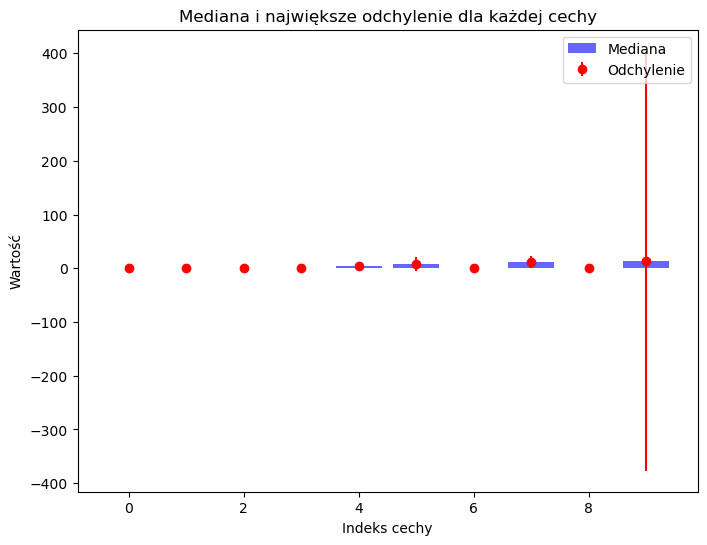

(330, 11)


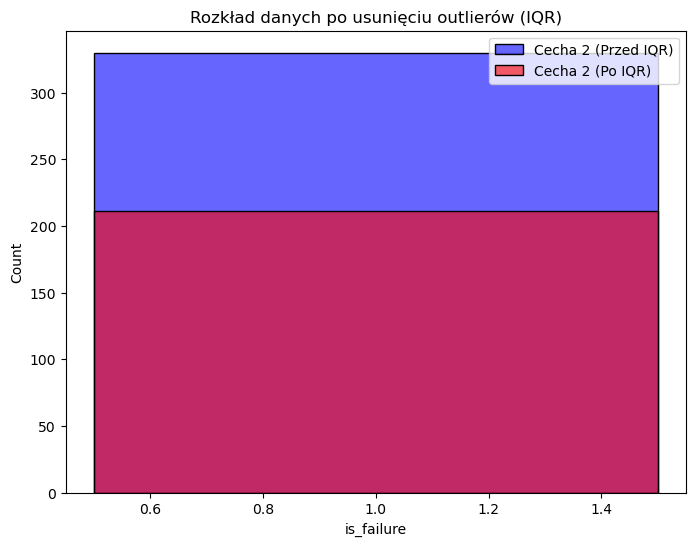

In [31]:
#sum_syn_data drop(columns=["source"])
syn_sum_data = sum_syn_data.drop(columns=["source"])
median = np.median(X_train_syn, axis=0)
std = np.std(X_train_syn, axis=0)
print(f"Mediana cech: {median}")
print(f"Największe odchylenie cech: {std}")
# Wizualizacja mediany i największego odchylenia
plt.figure(figsize=(8, 6))
plt.bar(range(len(median)), median, color='blue', alpha=0.6, label='Mediana')
plt.errorbar(range(len(median)), median, yerr=std, fmt='o', color='red', label='Odchylenie')
plt.xlabel("Indeks cechy")
plt.ylabel("Wartość")
plt.title("Mediana i największe odchylenie dla każdej cechy")
plt.legend()
plt.show()
print(syn_sum_data.shape)

def iqr_remove(data):
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = np.all((data>=lower) & (data<=upper), axis=1)
    X = data[mask]
    y = data[mask]
    return X, y

X, y = iqr_remove(syn_sum_data)

plt.figure(figsize=(8, 6))
sns.histplot(syn_sum_data.iloc[:, 1], kde=True, color='blue', label='Cecha 2 (Przed IQR)', alpha=0.6)
#plt.legend()
#plt.title("Rozkład danych przed usunięciem outlierów (IQR)")
#plt.show()

#plt.figure(figsize=(8, 6))
sns.histplot(X.iloc[:, 1], kde=True, color='red', label='Cecha 2 (Po IQR)', alpha=0.6)
plt.legend()
plt.title("Rozkład danych po usunięciu outlierów (IQR)")
plt.show()

### w pierwszej kolejnosci wykorzystuje sie rozklad dystrubucji, lub centroids i w ten spsob wyznacza sie w pierwszej kolejnosci istotne dane, a nastepnie uczac i uswujac dane sprawdzac czy wyniki uzyskiwane przez model sa takie same czy gorsze

### reduced to minimum number of samples

In [ ]:
# 1. trening modelu
# 2. usuwanie danych wiersz po wierszu
# 3. ponowne trenowanie modelu
# 4. zapisanie wyników
# 5. porównanie wyników
# jesli wyniki nie ulegl zmienie to wiersz zostaje usuniety
# else wiersz zostaje przywrócony
# 6. powtórzenie procesu dla kolejnego wiersza

#------------variabels----------------
# sum_data | median_data | if_data | lof_data | cc_data
df = sum_data.copy()
tol = 0.0001
X_train_sum = sum_data.drop(columns=["target", "source"])
y_train_sum = sum_data["target"]

def model_xgb(X_train, y_train, X_test, y_test):
    xgb = XGBClassifier(subsample=0.6, max_depth=4, n_jobs=1)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    #feature_val = xgb.feature_importances_
    #df_feat_imbalance = pd.DataFrame(
    #    {"Features": X_train_sum.columns, "Importance": feature_val}
    #)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

def eval_with_cross_vali(X, y):
    model = XGBClassifier(subsample = 0.6, max_depth = 4, n_jobs = 1)
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10, random_state = 42)
    score = cross_val_score(model, X, y, cv = cv, scoring = "accuracy")
    return np.mean(score)

def iter_data_remove(df, X, y, tol = tol):
    
    imb_score = eval_with_cross_vali(X, y)
    print(f"Imbalanced data score: {imb_score:.4f}")
    
    to_remove = []
    for index in X.index:
        X_tem = X.drop(index)
        y_tem = y.drop(index)
        
        new_score = eval_with_cross_vali(X_tem, y_tem)
        
        if np.isclose(new_score, imb_score, atol = tol):
            to_remove.append(index)
            print(f"Row {index} => {new_score:.4f}")
        else:
            print(f"Row {index} => {new_score:.4f}")
            
    df_clean = df.drop(index = to_remove)
    return df_clean, imb_score


print(iter_data_remove(df, X_train_sum, y_train_sum, tol=tol))
#=====================================================================
"""     
results_matrix = []

#imblanaced data calculation
original_data_mean, original_data_std = cross_validation(model, X_train_sum, y_train_sum)
results_matrix = pd.DataFrame(columns=["Source", "Mean", "Std"])
results_matrix = pd.concat([results_matrix, pd.DataFrame([{"Source": "Imbalanced data", "Mean": original_data_mean, "Std": original_data_std}])])
#results_matrix.append(("Imbalanced data results\n",original_data_mean, original_data_std))

for index in df.index:
    row = df.loc[[index]].copy()
    df_dropped = df.drop(index)
    X_train = df_dropped.drop(columns=["target", "source"])
    y_train = df_dropped['target']

    # Wytrenuj model i przeprowadź walidację krzyżową
    results_mean, results_std = cross_validation(model, X_train, y_train)

    # Zapisz wyniki do macierzy
    results_matrix = pd.concat([results_matrix, pd.DataFrame([{"Source": index, "Mean": results_mean, "Std": results_std}])])

    if np.allclose(original_data_mean, results_mean) and np.allclose(original_data_std, results_std):
        df.drop(index, inplace=True)
    else:
        df.loc[index] = row.values[0]

# Konwersja wyników do DataFrame dla lepszej czytelności
results_df = pd.DataFrame(results_matrix, columns=['Precision', 'F1', 'Recall', 'Accuracy', "Model"])

# Zapisz wyniki do pliku CSV
#results_df.to_csv('results_matrix.csv', index=False)

# Wyświetl wynik
print(results_df) """

df_clean, imb_score = iter_data_remove(df, X_train_sum, y_train_sum, tol=tol)

Imbalanced data score: 0.9747
Row 0 => 0.9756
Row 1 => 0.9741
Row 2 => 0.9743
Row 3 => 0.9736
Row 4 => 0.9745
Row 5 => 0.9736
Row 6 => 0.9743
Row 7 => 0.9743
Row 8 => 0.9741
Row 9 => 0.9745
Row 10 => 0.9754
Row 11 => 0.9736
Row 12 => 0.9743
Row 13 => 0.9734
Row 14 => 0.9732
Row 15 => 0.9741
Row 16 => 0.9732
Row 17 => 0.9732
Row 18 => 0.9747
Row 19 => 0.9732
Row 20 => 0.9732
Row 21 => 0.9736
Row 22 => 0.9741
Row 23 => 0.9740
Row 24 => 0.9732
Row 25 => 0.9739
Row 26 => 0.9736
Row 27 => 0.9721
Row 28 => 0.9745
Row 29 => 0.9725
Row 30 => 0.9743
Row 31 => 0.9723
Row 32 => 0.9725
Row 33 => 0.9725
Row 34 => 0.9715
Row 35 => 0.9730
Row 36 => 0.9726
Row 37 => 0.9738
Row 38 => 0.9728
Row 39 => 0.9732
Row 40 => 0.9732
Row 41 => 0.9738
Row 42 => 0.9736
Row 43 => 0.9732
Row 44 => 0.9736
Row 45 => 0.9732
Row 46 => 0.9727
Row 47 => 0.9728
Row 48 => 0.9741
Row 49 => 0.9747
Row 50 => 0.9738
Row 51 => 0.9728
Row 52 => 0.9741
Row 53 => 0.9741
Row 54 => 0.9739
Row 55 => 0.9738
Row 56 => 0.9741
Row 57 => 0

'     \nresults_matrix = []\n\n#imblanaced data calculation\noriginal_data_mean, original_data_std = cross_validation(model, X_train_sum, y_train_sum)\nresults_matrix = pd.DataFrame(columns=["Source", "Mean", "Std"])\nresults_matrix = pd.concat([results_matrix, pd.DataFrame([{"Source": "Imbalanced data", "Mean": original_data_mean, "Std": original_data_std}])])\n#results_matrix.append(("Imbalanced data results\n",original_data_mean, original_data_std))\n\nfor index in df.index:\n    row = df.loc[[index]].copy()\n    df_dropped = df.drop(index)\n    X_train = df_dropped.drop(columns=["target", "source"])\n    y_train = df_dropped[\'target\']\n\n    # Wytrenuj model i przeprowadź walidację krzyżową\n    results_mean, results_std = cross_validation(model, X_train, y_train)\n\n    # Zapisz wyniki do macierzy\n    results_matrix = pd.concat([results_matrix, pd.DataFrame([{"Source": index, "Mean": results_mean, "Std": results_std}])])\n\n    if np.allclose(original_data_mean, results_mean) a

In [ ]:
#------------variabels----------------
# sum_data | median_data | if_data | lof_data | cc_data
#df_clean, imb_score = iter_data_remove(df, X_train_sum, y_train_sum, tol=tol)
df_clean, imb_score = iter_data_remove(df, X_train_sum, y_train_sum, tol=tol)
df_clean, imb_score = iter_data_remove(df, X_train_sum, y_train_sum, tol=tol)

In [8]:
df_clean, imb_score = iter_data_remove(df, X_train_sum, y_train_sum, tol=tol)

Imbalanced data score: 0.9747
Row 0 => 0.9756
Row 1 => 0.9741
Row 2 => 0.9743
Row 3 => 0.9736
Row 4 => 0.9745
Row 5 => 0.9736
Row 6 => 0.9743
Row 7 => 0.9743
Row 8 => 0.9741
Row 9 => 0.9745
Row 10 => 0.9754
Row 11 => 0.9736
Row 12 => 0.9743
Row 13 => 0.9734
Row 14 => 0.9732
Row 15 => 0.9741
Row 16 => 0.9732
Row 17 => 0.9732
Row 18 => 0.9747
Row 19 => 0.9732
Row 20 => 0.9732
Row 21 => 0.9736
Row 22 => 0.9741
Row 23 => 0.9740
Row 24 => 0.9732
Row 25 => 0.9739
Row 26 => 0.9736
Row 27 => 0.9721
Row 28 => 0.9745
Row 29 => 0.9725
Row 30 => 0.9743
Row 31 => 0.9723
Row 32 => 0.9725
Row 33 => 0.9725
Row 34 => 0.9715
Row 35 => 0.9730
Row 36 => 0.9726
Row 37 => 0.9738
Row 38 => 0.9728
Row 39 => 0.9732
Row 40 => 0.9732
Row 41 => 0.9738
Row 42 => 0.9736
Row 43 => 0.9732
Row 44 => 0.9736
Row 45 => 0.9732
Row 46 => 0.9727
Row 47 => 0.9728
Row 48 => 0.9741
Row 49 => 0.9747
Row 50 => 0.9738
Row 51 => 0.9728
Row 52 => 0.9741
Row 53 => 0.9741
Row 54 => 0.9739
Row 55 => 0.9738
Row 56 => 0.9741
Row 57 => 0

In [11]:
print(df_clean.shape)
print(X_train_syn.shape)

(516, 12)
(330, 10)


In [12]:
df_clean.to_csv("D:\\ml\\undersampling_data\\data\\ssh\\red_min\\reduced_sum_data.csv", index=False)

In [ ]:
sum_data.shape

(546, 12)